# 🏡 California Housing Dataset
Este notebook demuestra cómo automatizar la descarga de un conjunto de datos desde internet, descomprimirlo y cargarlo en un DataFrame para su análisis.

**Contexto:**
Los datos que veremos a continuación fueron extraidos del censo de California de 1990. El conjunto de datos contiene información sobre el precio de las viviendas en California, así como características demográficas y socioeconómicas de las áreas. Algunas de las variables son: población, ingresos, número de habitaciones, etc.

## 1. Importar librerías necesarias

In [1]:
# PEP8 es una guía de estilo para escribir código Python. (https://www.python.org/dev/peps/pep-0008/)

# Librerías estándar de python
import os
import tarfile
import urllib.request as request
import datetime
import json
import logging

# Librerías de terceros
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

# Librerías locales
# from mi_clase import AwsStorage

%matplotlib inline

## 2. Definir rutas y URL del dataset

In [2]:
# Las constantes son variables que no deberían cambiar su valor a lo largo del programa.
# Por convención, se escriben en mayúsculas y con guiones bajos para separar palabras.

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# Creación de constante de forma alternativa:
HOUSING_URL2 = f"{DOWNLOAD_ROOT}datasets/housing/housing.tgz"

In [3]:
print(HOUSING_URL)

https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz


In [4]:
print(HOUSING_URL2)

https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz


## 3. Extracción de los datos

In [5]:
def fetch_housing_data(housing_url: str = HOUSING_URL, housing_path: str = HOUSING_PATH) -> None:
    # Validamos que el directorio de destino exista, y si no, lo creamos.
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)

    # Creamos una variables para almacenar la ruta del archivo comprimido.
    tgz_path = os.path.join(housing_path, "housing.tgz")

    # Descargamos el archivo comprimido desde la URL proporcionada y lo guardamos en la ruta especificada.
    request.urlretrieve(housing_url, tgz_path)

    # Abrimos el archivo comprimido y extraemos su contenido en el directorio especificado.
    # housing_tgz = tarfile.open(tgz_path)
    # housing_tgz.extractall(path=housing_path)
    # housing_tgz.close()

    # Solución alternativa para extraer el contenido del archivo comprimido. Utilizando context manager.
    with tarfile.open(tgz_path, "r:gz") as f:
        f.extractall(path=housing_path)

In [6]:
# Llamamos a la función para descargar los datos
fetch_housing_data()

In [7]:
# Podemos listar los archivos que se han descargado para verificar que todo está correcto.
!ls -l {HOUSING_PATH}

total 5120
-rw-r--r--@ 1 hrodriguez  staff  1423529 May  3  2016 housing.csv
-rw-r--r--@ 1 hrodriguez  staff   409488 Jun  4 20:16 housing.tgz


## 4. Carga de los datos

In [8]:
def load_housing_data(housing_path: str = HOUSING_PATH) -> pd.DataFrame:
    # Definimos una variable que almacena la ruta del archivo CSV dentro del directorio de datos.
    csv_path = os.path.join(housing_path, "housing.csv")
    # Leemos el archivo CSV y lo convertimos en un DataFrame de pandas.
    return pd.read_csv(csv_path)

In [9]:
# Llamamos a la función para cargar los datos en un DataFrame de pandas.
# El resultado de la función lo almacenamos en una variable llamada `housing`.
housing = load_housing_data()

# Presentamos las primeras 5 filas del DataFrame para verificar que los datos se han cargado correctamente.
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## 5. EDA: Exploración de Datos

### 5.1 Tipos de datos

In [10]:
# El método `info()` nos proporciona un resumen del DataFrame, incluyendo el número de entradas, tipos de datos y valores no nulos.
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [11]:
# Para el caso de la variable `ocean_proximity`, que es de tipo objeto (string), podemos utilizar el método `value_counts()`
# para ver la cantidad de ocurrencias de cada categoría.
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

### 5.2 Estadísticas descriptivas

In [12]:
# El método `describe()` nos proporciona estadísticas descriptivas de las columnas numéricas del DataFrame.
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### 5.3 Histograma de las variables numéricas

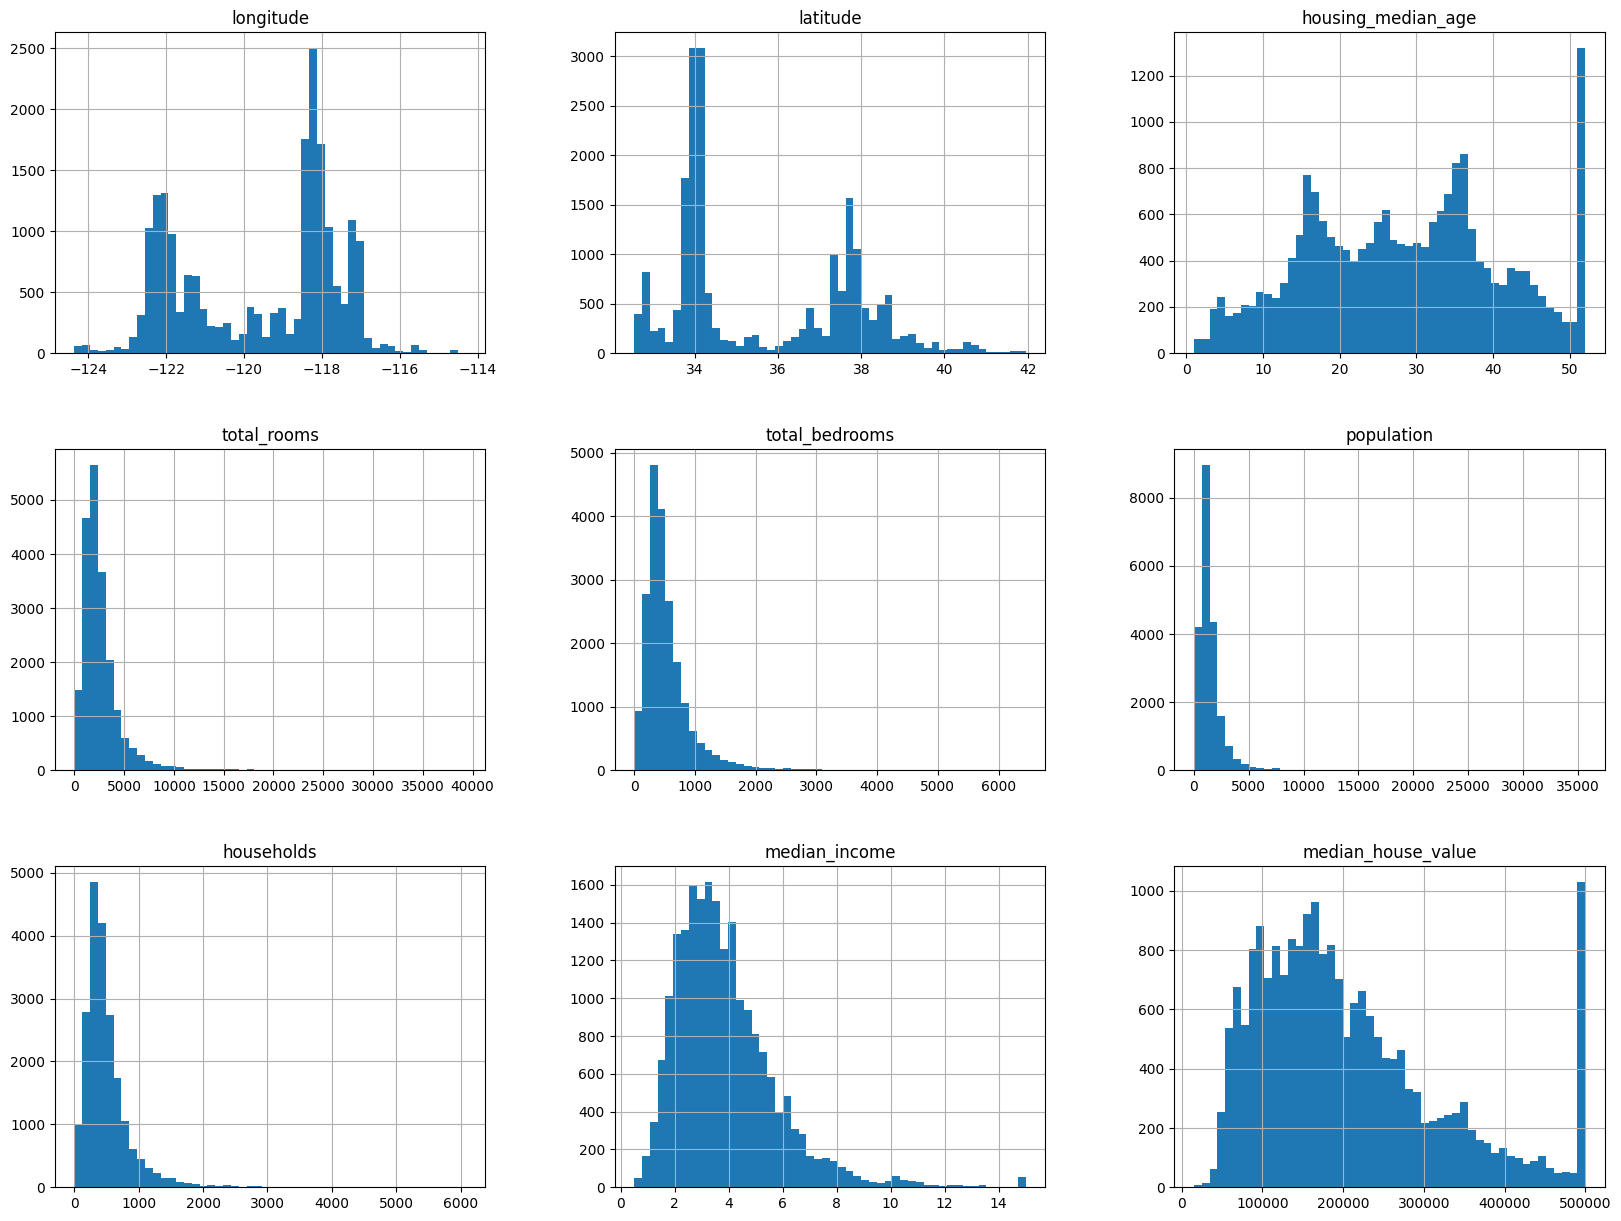

In [13]:
# El método `hist()` nos permite visualizar la distribución de los datos numéricos en el DataFrame.
housing.hist(bins=50, figsize=(20, 15))
plt.show()

### 5.4 Análisis de correlación

In [14]:
corr_matrix = housing.loc[:, housing.columns != "ocean_proximity"].corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

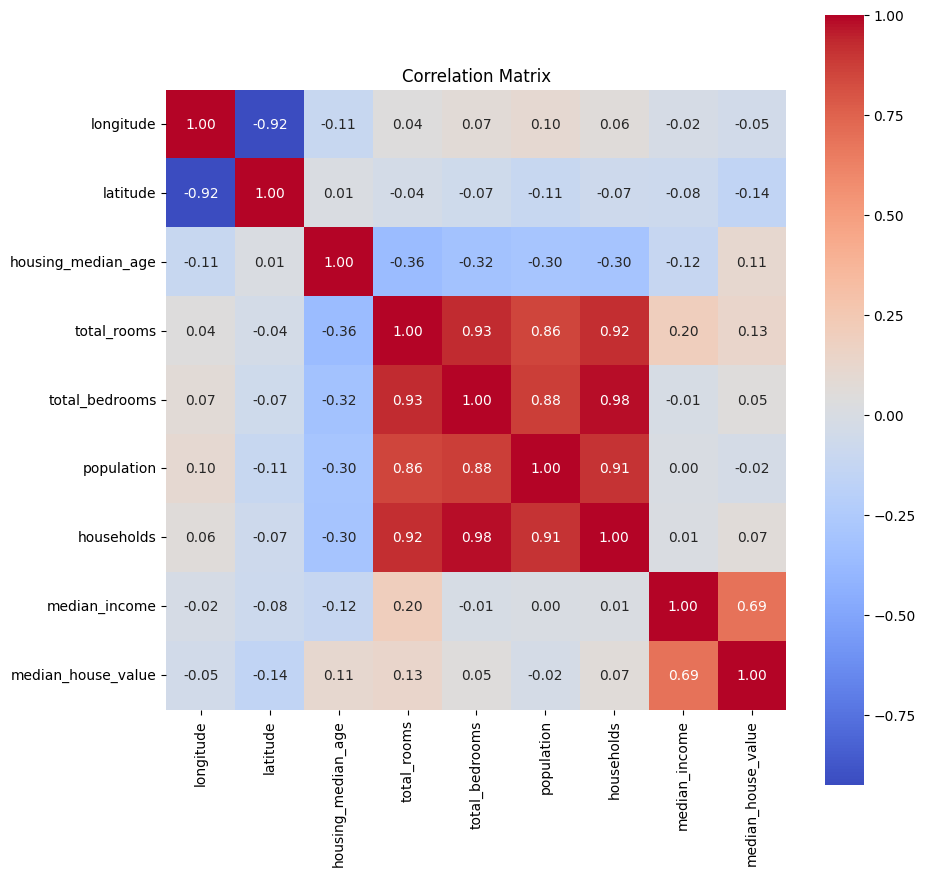

In [15]:
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

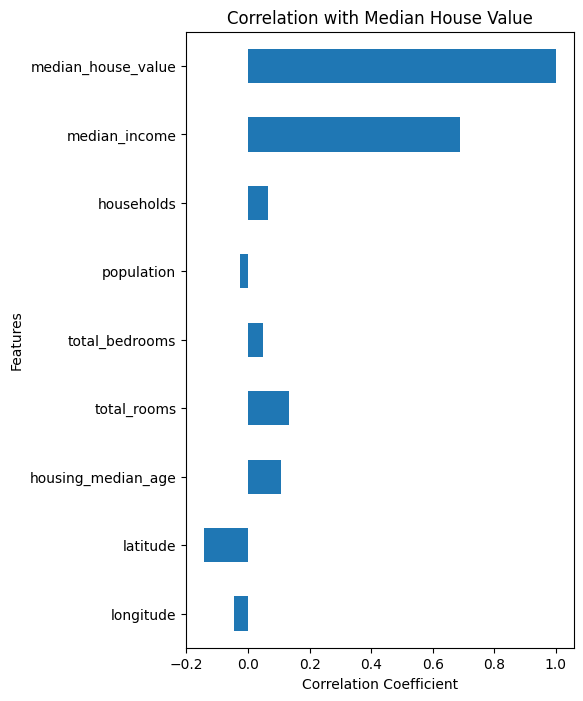

In [16]:
corr_matrix["median_house_value"].plot(kind="barh", figsize=(5, 8))
plt.title("Correlation with Median House Value")
plt.ylabel("Features")
plt.xlabel("Correlation Coefficient")
plt.show()

### 5.5 Ingeniería de características

Este proceso requiere de conocimiento de negocio y del contexto de los datos. Aquí, simplemente mostraremos cómo se puede realizar un enriquecimiento
básico de los datos.

In [17]:
# En el dataset de entrenamiento, la columna `rooms_per_household` no existe, la crearemos a partir de la división de las columnas `total_rooms` y `households`.
# Esta nueva columna representará el número promedio de habitaciones por hogar en cada fila del DataFrame.
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]

# De manera similar, crearemos las columnas `bedrooms_per_room` y `population_per_household` para analizar la relación entre el número de dormitorios,
# el número total de habitaciones y la población por hogar, respectivamente.
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [18]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,0.155797,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136,0.129516,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352,0.184458,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853,0.172096,2.181467


In [19]:
housing.drop(columns=["rooms_per_household", "bedrooms_per_room", "population_per_household"], inplace=True)

In [20]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## 6. Preparación de los datos
En esta sección prepararemos los datos para un futuro modelo de machine learning. Esto incluye manejo de valores faltantes, codificación de variables categóricas, y separación de variables predictoras y objetivo.

### 6.1 Dividir el conjunto de datos entre Train y Test

In [21]:
# La función `train_test_split` de `sklearn.model_selection` se utiliza para dividir el conjunto de datos en conjuntos de entrenamiento y prueba.
# En este caso, estamos dividiendo el DataFrame `housing` en dos conjuntos: `housing_train` y `housing_test`.
# El parámetro `test_size=0.2` indica que el 20% de los datos se utilizarán para el conjunto de prueba.
# El parámetro `random_state=42` asegura que la división sea reproducible, es decir, cada vez que se ejecute el código, se obtendrá la misma división.
# El parámetro `shuffle=False` indica que no se debe mezclar el orden de los datos antes de la división, lo cual es importante en este caso

housing_train, housing_test = train_test_split(housing, test_size=0.2, random_state=42, shuffle=False)

In [22]:
# Vemos los datos de entrenamiento.
housing_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [23]:
# El atributo `shape` de un DataFrame nos proporciona una tupla que indica el número de filas y columnas del DataFrame.
housing_train.shape

(16512, 10)

In [24]:
housing_test.shape

(4128, 10)

### 6.2 Separar las variables independientes de la variable objetivo

Separaremos nuestro dataset en `X` (las columnas que usaremos para predecir) y `y` (la variable que queremos predecir: `median_house_value`).

In [25]:
housing = housing_train.drop("median_house_value", axis=1)
housing_labels = housing_train["median_house_value"].copy()

### 6.3 Limpieza de datos

#### 6.3.1. Manejo de valores faltantes
Primero identificamos columnas con valores faltantes. Luego decidiremos si los eliminamos o los imputamos (rellenamos).

In [26]:
# Contamos cuántos valores faltantes hay en cada columna
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        159
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

Vemos que la columna `total_bedrooms` contiene valores faltantes. Vamos a reemplazarlos con la **mediana** de esa columna.

In [27]:
# SimpleImputer es una clase de sklearn que se utiliza para manejar los valores faltantes en un conjunto de datos.
# En este caso, estamos utilizando la estrategia "median" para imputar los valores faltantes, lo que significa que se reemplazarán los valores
# faltantes con la mediana de cada columna.
imputer = SimpleImputer(strategy="median")

In [28]:
# Dado que la imputación de datos solo se puede aplicar a columnas numéricas, vamos a crear un nuevo DataFrame que contenga solo las columnas numéricas.
housing_num = housing.drop("ocean_proximity", axis=1)

In [29]:
# Ahora si podemos ajustar el imputador a los datos numéricos.
imputer.fit(housing_num)

# El atributo `statistics_` del imputador contiene las estadísticas utilizadas para imputar los valores faltantes.
imputer.statistics_

array([-118.3  ,   34.1  ,   30.   , 2105.   ,  436.   , 1168.   ,
        410.   ,    3.475])

In [30]:
# Ya con el imputador ajustado, podemos transformar los datos numéricos para reemplazar los valores faltantes con las medianas calculadas.
# El método `transform` aplica la imputación a los datos numéricos, devolviendo un nuevo array con los valores imputados.
# Este array tendrá la misma forma que el DataFrame original, pero con los valores faltantes reemplazados por las medianas correspondientes.
X = imputer.transform(housing_num)

# Convertimos el array resultante de la imputación de datos en un DataFrame de pandas.
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462


In [31]:
# Validamos que ya no hay valores faltantes en el DataFrame imputado.
housing_tr.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

#### 6.3.2. Codificación de variables categóricas
La columna `ocean_proximity` es de tipo texto (categórica). Vamos a convertirla en variables numéricas usando codificación *one-hot*.

In [32]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY
5,NEAR BAY
6,NEAR BAY
7,NEAR BAY
8,NEAR BAY
9,NEAR BAY


In [33]:
# OrdinalEncoder es una clase de sklearn que se utiliza para convertir variables categóricas en variables numéricas.
# En este caso, estamos utilizando OrdinalEncoder para codificar la columna "ocean_proximity", que contiene categorías de tipo string.
# La codificación ordinal asigna un número entero a cada categoría, lo que permite que el modelo de machine learning pueda trabajar con estas
# variables categóricas.
encoder = OrdinalEncoder()
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.]])

In [34]:
# El atributo `categories_` del codificador contiene las categorías originales de la variable categórica, en el orden en que fueron codificadas.
encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [35]:
# OneHotEncoder es otra clase de sklearn que se utiliza para convertir variables categóricas en variables numéricas, pero a diferencia de OrdinalEncoder,
# OneHotEncoder crea variables binarias (0 o 1) para cada categoría de la variable categórica.
# Esto es útil cuando las categorías no tienen un orden inherente, ya que evita que el modelo interprete las categorías codificadas ordinalmente
# como si tuvieran un orden.
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [36]:
# El atributo `categories_` del codificador contiene las categorías originales de la variable categórica, en el orden en que fueron codificadas.
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [37]:
# Para efectos de este ejercicio, convertimos el resultado de OneHotEncoder a un DataFrame de pandas. Este lo utilizaremos más adelante.
housing_cat_1hot = pd.DataFrame(housing_cat_1hot.toarray(), columns=cat_encoder.get_feature_names_out(), index=housing_cat.index)

#### 6.3.3. Escalar las variables numéricas

El escalado es importante para que todas las variables numéricas tengan un rango comparable, especialmente si vamos a usar modelos sensibles a magnitudes como regresión lineal o redes neuronales.

In [38]:
# StandardScaler es una clase de sklearn que se utiliza para escalar las características numéricas de un conjunto de datos.
scaler = StandardScaler()
housing_num_tr = scaler.fit_transform(housing_tr)

# Convertimos el array resultante de la transformación del escalador en un DataFrame de pandas.
housing_num_tr = pd.DataFrame(housing_num_tr, columns=housing_tr.columns, index=housing_tr.index)

In [39]:
housing_num_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-1.611695,1.258392,0.916627,-0.780765,-0.954574,-0.961217,-0.960953,2.417615
1,-1.606494,1.248807,-0.647225,1.983551,1.297033,0.830056,1.614396,2.404898
2,-1.616896,1.244014,1.776746,-0.519846,-0.813992,-0.811298,-0.831168,1.847079
3,-1.622097,1.244014,1.776746,-0.605634,-0.710285,-0.757879,-0.724286,0.984544
4,-1.622097,1.244014,1.776746,-0.448727,-0.606577,-0.751848,-0.622493,0.024444


In [40]:
# Combinamos numéricas escaladas + categóricas codificadas
housing_prepared = pd.concat([housing_num_tr, housing_cat_1hot], axis=1)
housing_prepared.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-1.611695,1.258392,0.916627,-0.780765,-0.954574,-0.961217,-0.960953,2.417615,0.0,0.0,0.0,1.0,0.0
1,-1.606494,1.248807,-0.647225,1.983551,1.297033,0.830056,1.614396,2.404898,0.0,0.0,0.0,1.0,0.0
2,-1.616896,1.244014,1.776746,-0.519846,-0.813992,-0.811298,-0.831168,1.847079,0.0,0.0,0.0,1.0,0.0
3,-1.622097,1.244014,1.776746,-0.605634,-0.710285,-0.757879,-0.724286,0.984544,0.0,0.0,0.0,1.0,0.0
4,-1.622097,1.244014,1.776746,-0.448727,-0.606577,-0.751848,-0.622493,0.024444,0.0,0.0,0.0,1.0,0.0


#### 6.4 Uso de `Pipeline` de Scikit-learn

Los pasos que se han realizado anteriormente de:
- Manejo de valores faltantes
- Codificación de variables categóricas
- Escalado de variables numéricas

Pueden ser encapsulados en un `Pipeline` de Scikit-learn. Esto nos permite aplicar todas estas transformaciones de manera secuencial y ordenada.

In [41]:
# Pipeline es una clase de sklearn que se utiliza para encadenar múltiples pasos de procesamiento de datos en un solo objeto.
# En este caso, estamos creando un pipeline que primero imputa los valores faltantes en las columnas numéricas utilizando la mediana,
# y luego escala las características numéricas utilizando StandardScaler.
num_pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])

# Ahora aplicamos el pipeline a las columnas numéricas del DataFrame `housing_num`.
# El método `fit_transform` ajusta el pipeline a los datos numéricos y luego transforma esos datos, devolviendo un nuevo array con los valores imputados y escalados.
# Este array tendrá la misma forma que el DataFrame original, pero con los valores faltantes reemplazados por las medianas correspondientes y las características escaladas.
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [42]:
# Ya con las transformaciones definidas en el pipeline, podemos crear un `ColumnTransformer` que nos permitirá aplicar diferentes transformaciones
# a diferentes columnas del DataFrame.

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

# ColumnTransformer es una clase de sklearn que se utiliza para aplicar diferentes transformaciones a diferentes columnas de un DataFrame.
# En este caso, estamos creando un ColumnTransformer que aplica el pipeline de transformación numérica a las columnas numéricas
# y utiliza OneHotEncoder para codificar las columnas categóricas.
full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs), ("cat", OneHotEncoder(), cat_attribs)])

housing_prepared = full_pipeline.fit_transform(housing)

In [43]:
housing_prepared = pd.DataFrame(housing_prepared, columns=num_attribs + list(cat_encoder.get_feature_names_out()), index=housing.index)

housing_prepared.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-1.611695,1.258392,0.916627,-0.780765,-0.954574,-0.961217,-0.960953,2.417615,0.0,0.0,0.0,1.0,0.0
1,-1.606494,1.248807,-0.647225,1.983551,1.297033,0.830056,1.614396,2.404898,0.0,0.0,0.0,1.0,0.0
2,-1.616896,1.244014,1.776746,-0.519846,-0.813992,-0.811298,-0.831168,1.847079,0.0,0.0,0.0,1.0,0.0
3,-1.622097,1.244014,1.776746,-0.605634,-0.710285,-0.757879,-0.724286,0.984544,0.0,0.0,0.0,1.0,0.0
4,-1.622097,1.244014,1.776746,-0.448727,-0.606577,-0.751848,-0.622493,0.024444,0.0,0.0,0.0,1.0,0.0


### 7. Selección y entrenamiento del modelo

In [44]:
# LinearRegression es una clase de sklearn que se utiliza para crear un modelo de regresión lineal.
# En este caso, estamos creando un modelo de regresión lineal que se ajustará a los datos preparados.
lin_reg = LinearRegression()

# El método `fit` se utiliza para entrenar el modelo de regresión lineal con los datos preparados y las etiquetas correspondientes.
# `housing_prepared` contiene las características de entrada y `housing_labels` contiene las etiquetas de salida (valores medianos de las casas).
# Al llamar a `fit`, el modelo ajustará sus parámetros para minimizar la diferencia entre las predicciones y las etiquetas reales.
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

### 8. Ejecución de predicciones

In [ ]:
# Utilizando los datos de prueba, separamos las características y las etiquetas.
# `housing_test` es el DataFrame que contiene los datos de prueba, y `median_house_value` es la columna que contiene las etiquetas (valores medianos de las casas).
housing_in = housing_test.drop("median_house_value", axis=1)
housing_labels_in = housing_test["median_house_value"].copy()

In [50]:
# Haciendo uso del pipeline completo, transformamos los datos de prueba para que tengan el mismo formato que los datos de entrenamiento.
datos_preparados = full_pipeline.transform(housing_in)
predicciones = lin_reg.predict(datos_preparados)

print("Predicciones:", predicciones[:5])

Predicciones: [112105.1684931  131104.41122965  93385.80476713 105789.0995221
 114830.54751811]


/Users/hrodriguez/Github/introduccion_ml/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Confirmamos que `y` sigue alineado correctamente.

In [51]:
print("Reales:", list(housing_labels_in[:5]))

Reales: [165600.0, 126100.0, 94400.0, 91900.0, 124300.0]


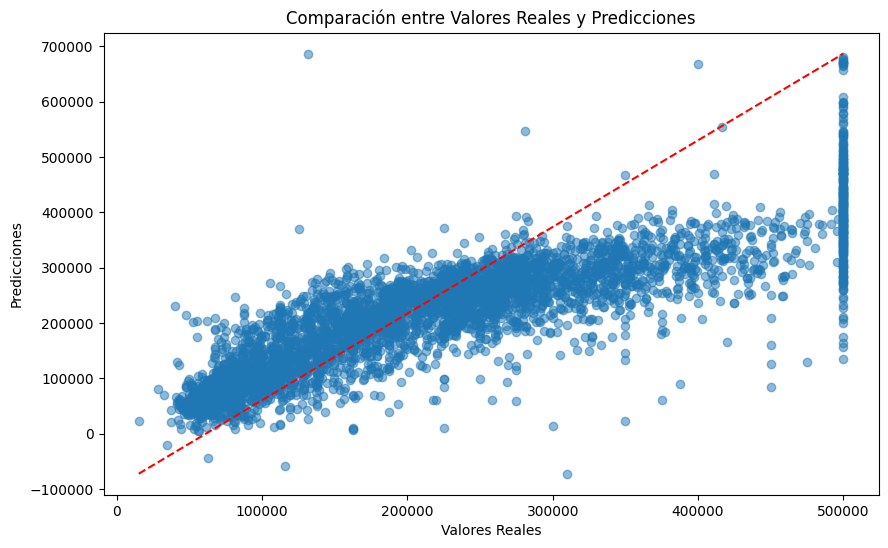

In [57]:
plt.figure(figsize=(10, 6))
plt.scatter(housing_labels_in, predicciones, alpha=0.5)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Comparación entre Valores Reales y Predicciones")
plt.plot([housing_labels_in.min(), housing_labels_in.max()], [predicciones.min(), predicciones.max()], color="red", linestyle="--")
plt.show()

### 9. Evaluación del modelo

En esta sección evaluaremos el rendimiento del modelo utilizando métricas como RMSE (Raíz del Error Cuadrático Medio) y R² (Coeficiente de Determinación).

In [58]:
# means_squared_error es una función de sklearn que se utiliza para calcular el error cuadrático medio entre las predicciones y las etiquetas reales.
# En este caso, estamos calculando el error cuadrático medio entre las etiquetas reales (`housing_labels_in`) y las predicciones realizadas por el modelo (`predicciones`).
mse = mean_squared_error(housing_labels_in, predicciones)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 66503.44762842033


🎉 ¡Listo! Hemos preparado un dataset completamente procesado para entrenar modelos de machine learning.

In [59]:
r2 = r2_score(housing_labels_in, predicciones)
print("R^2:", r2)

R^2: 0.6964840512951385


Entendiendo las métricas:
- **RMSE**: Mide el error promedio entre las predicciones del modelo y los valores reales.
    - Se calcula como la raíz cuadrada del error cuadrático medio (MSE).
    - Interpretación: valores más bajos indican mejor desempeño.
    - Está en la misma unidad que la variable objetivo (median_house_value en este caso).
- **R²**: Indica qué porcentaje de la variabilidad en los datos es explicado por el modelo.
    - Su valor va de 0 a 1 (en algunos casos puede ser negativo).
    - Un valor de 0.85 significa que el modelo explica el 85% de la variabilidad de los datos.